# Prova Substitutiva

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F, SparkSession
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Carregando os dados

In [2]:
df_092020 = pd.read_csv("assets/PNAD_COVID_092020.csv")
df_102020 = pd.read_csv("assets/PNAD_COVID_102020.csv")
df_112020 = pd.read_csv("assets/PNAD_COVID_112020.csv")

## Renomeando a coluna Mês

In [3]:
df_092020.rename(columns={'V1013': 'Mês'}, inplace=True)
df_102020.rename(columns={'V1013': 'Mês'}, inplace=True)
df_112020.rename(columns={'V1013': 'Mês'}, inplace=True)

## Realizando o merge dos dados

In [4]:
df_merged = pd.concat([df_092020, df_102020, df_112020], ignore_index=True)

## Escolhendo as colunas que serão utilizadas
1. Características dos Moradores:
- A002: Idade;
- A003: Sexo;
- A004: Cor ou Raça;
- A005: Escolaridade;

2. Sintomas:
- B0011: Na semana passada teve febre?
- B0012: Na semana passada teve tosse?
- B0013: Na semana passada teve dor de garganta?
- B0014: Na semana passada teve dificuldade para respirar?
- B0015: Na semana passada teve dor de cabeça?
- B0016: Na semana passada teve dor no peito?
- B0017: Na semana passada teve náusea?
- B0018: Na semana passada teve nariz entupido ou escorrendo?
- B0019: Na semana passada teve fadiga?
- B00110: Na semana passada teve dor nos olhos?
- B00111: Na semana passada teve perda de cheiro ou sabor?
- B00112: Na semana passada teve dor muscular?

3. Características de trabalho das pessoas de 14 anos ou mais de idade:
- C001: Na semana passada, por pelo menos uma hora, trabalhou ou fez algum bico?
- C002: Na semana passada, estava temporariamente afastado de algum trabalho?
- C005: Há quanto tempo está afastado desse trabalho?

## Removendo colunas desnecessárias

In [5]:
columns_to_remove = [
    "RM_RIDE", "V1008", "V1012", "V1016", "Estrato", "UPA", "V1022", "V1023", "V1030", "V1031", "V1032", "posest",
    "CAPITAL", "A006", "A006A", "A006B", "A007", "A007A", "A008", "A009", "B00113", "B008", "B009A", "B009B", "B009C", 
    "B009D", "B009E", "B009F", "B0101", "B0102", "B0103", "B0104", "B0105", "B0106", "B011", "C007F", "C009A", "E001", 
    "E0021", "E0022", "E0023", "E0024", "F002A1", "F002A2", "F002A3", "F002A4", "F002A5",
    "A001", "A001A", "A001B1", "A001B2", "A001B3",
    "B002", "B0031", "B0032", "B0033", "B0034", "B0035", "B0036", "B0037", "B0041", "B0042", "B0043", "B0044", "B0045", 
    "B0046", "B005", "B006", "B007",
    "C003", "C004", "C0051", "C0052", "C0053", "C006", "C007", "C007A", "C007B", "C007C", "C007D", "C007E", "C007E1", 
    "C007E2", "C008", "C009", "C010", "C0101", "C01011", "C01012", "C0102", "C01021", "C01022", "C0103", "C0104", 
    "C011A", "C011A1", "C011A11", "C011A12", "C011A2", "C011A21", "C011A22", "C012", "C013", "C014", "C015", "C016", 
    "C017A",
    "D0011", "D0013", "D0021", "D0023", "D0031", "D0033", "D0041", "D0043", "D0051", "D0053", "D0061", "D0063", 
    "D0071", "D0073", "F001", "F0021", "F0022", "F0061", "F006"
]

df_merged = df_merged.drop(columns=columns_to_remove, axis=1)

## Atualizando o Dataframe com o mapeamento do dicionário do PNAD COVID-19

### Mapeando Códigos para UF

In [6]:
uf_mapping = {
    11: "Rondônia", 12: "Acre", 13: "Amazonas", 14: "Roraima", 15: "Pará",
    16: "Amapá", 17: "Tocantins", 21: "Maranhão", 22: "Piauí", 23: "Ceará",
    24: "Rio Grande do Norte", 25: "Paraíba", 26: "Pernambuco", 27: "Alagoas",
    28: "Sergipe", 29: "Bahia", 31: "Minas Gerais", 32: "Espírito Santo",
    33: "Rio de Janeiro", 35: "São Paulo", 41: "Paraná", 42: "Santa Catarina",
    43: "Rio Grande do Sul", 50: "Mato Grosso do Sul", 51: "Mato Grosso",
    52: "Goiás", 53: "Distrito Federal"
}

df_merged["UF"] = df_merged["UF"].astype(int).map(uf_mapping)

### Mapeando Idade

In [7]:
df_merged = df_merged.rename(columns={"A002": "Idade"})

### Mapeando Sexo

In [8]:
df_merged = df_merged.rename(columns={"A003": "Sexo"})

sexo_mapping = {1: "Homem", 2: "Mulher"}

df_merged["Sexo"] = df_merged["Sexo"].astype(int).map(sexo_mapping)

### Mapeando Cor/Raça

In [9]:
df_merged = df_merged.rename(columns={"A004": "Cor ou Raça"})

cor_raca_mapping = {
    1: "Branca",
    2: "Preta",
    3: "Amarela",
    4: "Parda",
    5: "Indígena",
    9: "Ignorado"
}

df_merged["Cor ou Raça"] = df_merged["Cor ou Raça"].astype(int).map(cor_raca_mapping)

### Mapeando Escolaridade

In [10]:
df_merged = df_merged.rename(columns={"A005": "Escolaridade"})

escolaridade_mapping = {
    1: "Sem instrução",
    2: "Fundamental incompleto",
    3: "Fundamental completo",
    4: "Médio incompleto",
    5: "Médio completo",
    6: "Superior incompleto",
    7: "Superior completo",
    8: "Pós-graduação, mestrado ou doutorado"
}

df_merged["Escolaridade"] = df_merged["Escolaridade"].astype(int).map(escolaridade_mapping)

### Mapeando Sintomas

In [11]:
sintomas_rename = {
    "B0011": "Febre", "B0012": "Tosse", "B0013": "Dor de Garganta", "B0014": "Dificuldade para Respirar",
    "B0015": "Dor de Cabeça", "B0016": "Dor no Peito", "B0017": "Náusea", "B0018": "Nariz Entupido ou Escorrendo",
    "B0019": "Fadiga", "B00110": "Dor nos Olhos", "B00111": "Perda de Cheiro ou Sabor", "B00112": "Dor Muscular"
}

df_merged = df_merged.rename(columns=sintomas_rename)

sintomas_mapping = {
    1: "Sim",
    2: "Não",
    3: "Não sabe",
    9: "Ignorado"
}

for coluna in sintomas_rename.values():
    df_merged[coluna] = df_merged[coluna].astype(int).map(sintomas_mapping)

### Mapeando Comportamento no Trabalho

In [12]:
trabalho_rename = {
    "C001": "Trabalhou",
    "C002": "Afastado",
    "C005": "Tempo Afastado"
}

df_merged = df_merged.rename(columns=trabalho_rename)

binario_mapping = {
    1: "Sim",
    2: "Não"
}

for coluna in ["Trabalhou", "Afastado"]:
    df_merged[coluna] = df_merged[coluna].fillna(-1).astype(int).map(binario_mapping).fillna("Não aplicável")

tempo_afastado_mapping = {
    1: "Menos de 1 mês",
    2: "De 1 mês a menos de 1 ano",
    3: "De 1 ano a menos de 2 anos",
    4: "2 anos ou mais"
}

df_merged["Tempo Afastado"] = df_merged["Tempo Afastado"].fillna(-1).astype(int).map(tempo_afastado_mapping).fillna("Não aplicável")

## Exibindo sample dos dados

In [13]:
df_merged.sample(10)

,Ano,UF,Mês,Idade,Sexo,Cor ou Raça,Escolaridade,Febre,Tosse,Dor de Garganta,...,Dor no Peito,Náusea,Nariz Entupido ou Escorrendo,Fadiga,Dor nos Olhos,Perda de Cheiro ou Sabor,Dor Muscular,Trabalhou,Afastado,Tempo Afastado
839593,2020,Piauí,11,36,Homem,Parda,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável
90102,2020,Ceará,9,60,Mulher,Branca,Fundamental completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável
478696,2020,Ceará,10,31,Homem,Parda,Médio incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável
541001,2020,Bahia,10,10,Homem,Parda,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não aplicável,Não aplicável,Não aplicável
458736,2020,Piauí,10,4,Homem,Parda,Sem instrução,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não aplicável,Não aplicável,Não aplicável
404734,2020,Amazonas,10,32,Homem,Parda,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não aplicável,Não aplicável
1135102,2020,Goiás,11,56,Mulher,Parda,Médio completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável
680645,2020,Paraná,10,57,Mulher,Parda,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável
846256,2020,Ceará,11,31,Homem,Parda,"Pós-graduação, mestrado ou doutorado",Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável
679195,2020,Paraná,10,65,Homem,Branca,Superior completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não aplicável,Não aplicável


In [14]:
df_merged.dtypes

Ano                              int64
UF                              object
Mês                              int64
Idade                            int64
Sexo                            object
Cor ou Raça                     object
Escolaridade                    object
Febre                           object
Tosse                           object
Dor de Garganta                 object
Dificuldade para Respirar       object
Dor de Cabeça                   object
Dor no Peito                    object
Náusea                          object
Nariz Entupido ou Escorrendo    object
Fadiga                          object
Dor nos Olhos                   object
Perda de Cheiro ou Sabor        object
Dor Muscular                    object
Trabalhou                       object
Afastado                        object
Tempo Afastado                  object
dtype: object

## Exportando para um arquivo .csv
Esse arquivo será usado para carregar os dados no Spark

In [15]:
df_merged.to_csv("assets/PNAD_COVID_LIMPO.csv", index=False, encoding="utf-8")

## Rodando o Spark

```shell
$ docker run -p 8080:8080 --name pnad_covid bitnami/spark:latest
```

Nota: o Java precisa estar instalado na máquina.

### Acessando a instância do Spark

In [16]:
spark = SparkSession.builder.appName("PNAD COVID-19").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/08 15:42:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Carregando o CSV limpo no Spark

In [17]:
df_spark = spark.read.csv("assets/PNAD_COVID_LIMPO.csv", header=True, inferSchema=True)
df_spark.toPandas().sample(10)

25/03/08 15:42:41 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


,Ano,UF,Mês,Idade,Sexo,Cor ou Raça,Escolaridade,Febre,Tosse,Dor de Garganta,...,Dor no Peito,Náusea,Nariz Entupido ou Escorrendo,Fadiga,Dor nos Olhos,Perda de Cheiro ou Sabor,Dor Muscular,Trabalhou,Afastado,Tempo Afastado
26668,2020,Roraima,9,38,Homem,Branca,Médio completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não aplicável,Não aplicável
980428,2020,Espírito Santo,11,12,Mulher,Parda,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não aplicável,Não aplicável,Não aplicável
12141,2020,Amazonas,9,18,Homem,Parda,Superior incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável
283104,2020,Paraná,9,0,Mulher,Branca,Sem instrução,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não aplicável,Não aplicável,Não aplicável
159853,2020,Bahia,9,26,Homem,Preta,Médio completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não aplicável,Não aplicável
531893,2020,Sergipe,10,44,Mulher,Parda,Médio completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não aplicável,Não aplicável
1130966,2020,Goiás,11,11,Mulher,Branca,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não aplicável,Não aplicável,Não aplicável
839617,2020,Piauí,11,13,Mulher,Parda,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não aplicável,Não aplicável,Não aplicável
953689,2020,Minas Gerais,11,35,Mulher,Parda,Fundamental completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não aplicável,Não aplicável
294993,2020,Paraná,9,61,Mulher,Branca,Médio incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável


## Análises

### Principais Sintomas

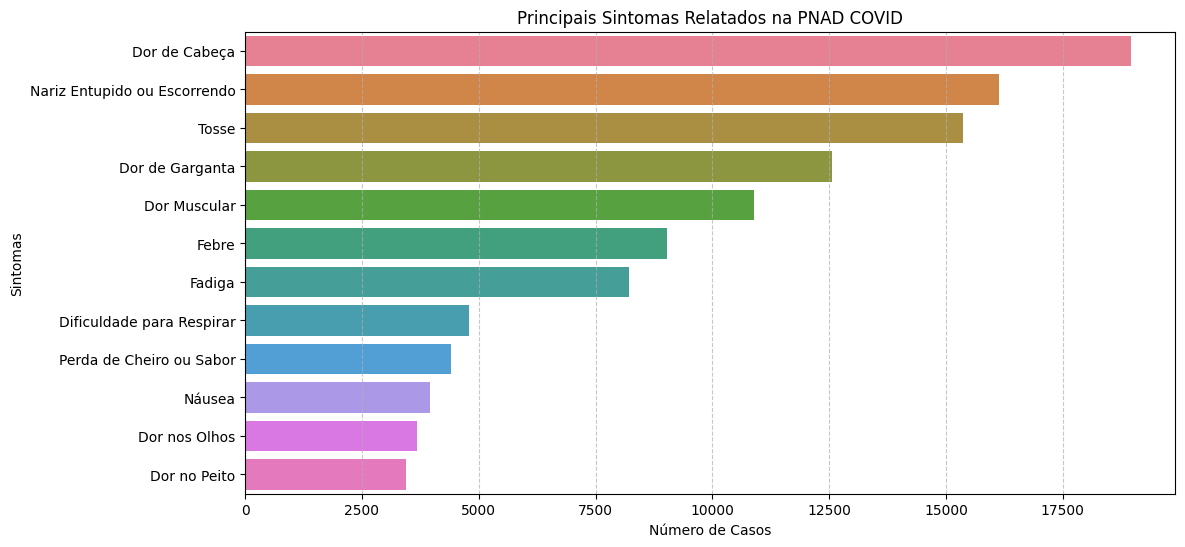

In [18]:
sintomas_cols = [
    "Febre", "Tosse", "Dor de Garganta", "Dificuldade para Respirar", "Dor de Cabeça",
    "Dor no Peito", "Náusea", "Nariz Entupido ou Escorrendo", "Fadiga", "Dor nos Olhos",
    "Perda de Cheiro ou Sabor", "Dor Muscular"
]

sintomas_freq = (
    df_spark.select(*sintomas_cols)
    .agg(*[F.sum(F.when(F.col(col) == "Sim", 1).otherwise(0)).alias(col) for col in sintomas_cols])
)

sintomas_freq_pd = sintomas_freq.toPandas().T.reset_index()
sintomas_freq_pd.columns = ["Sintoma", "Frequência"]
sintomas_freq_pd = sintomas_freq_pd.sort_values(by="Frequência", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=sintomas_freq_pd, x="Frequência", y="Sintoma", hue="Sintoma")
plt.xlabel("Número de Casos")
plt.ylabel("Sintomas")
plt.title("Principais Sintomas Relatados na PNAD COVID")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

### Maior Público Atingido pela Doença

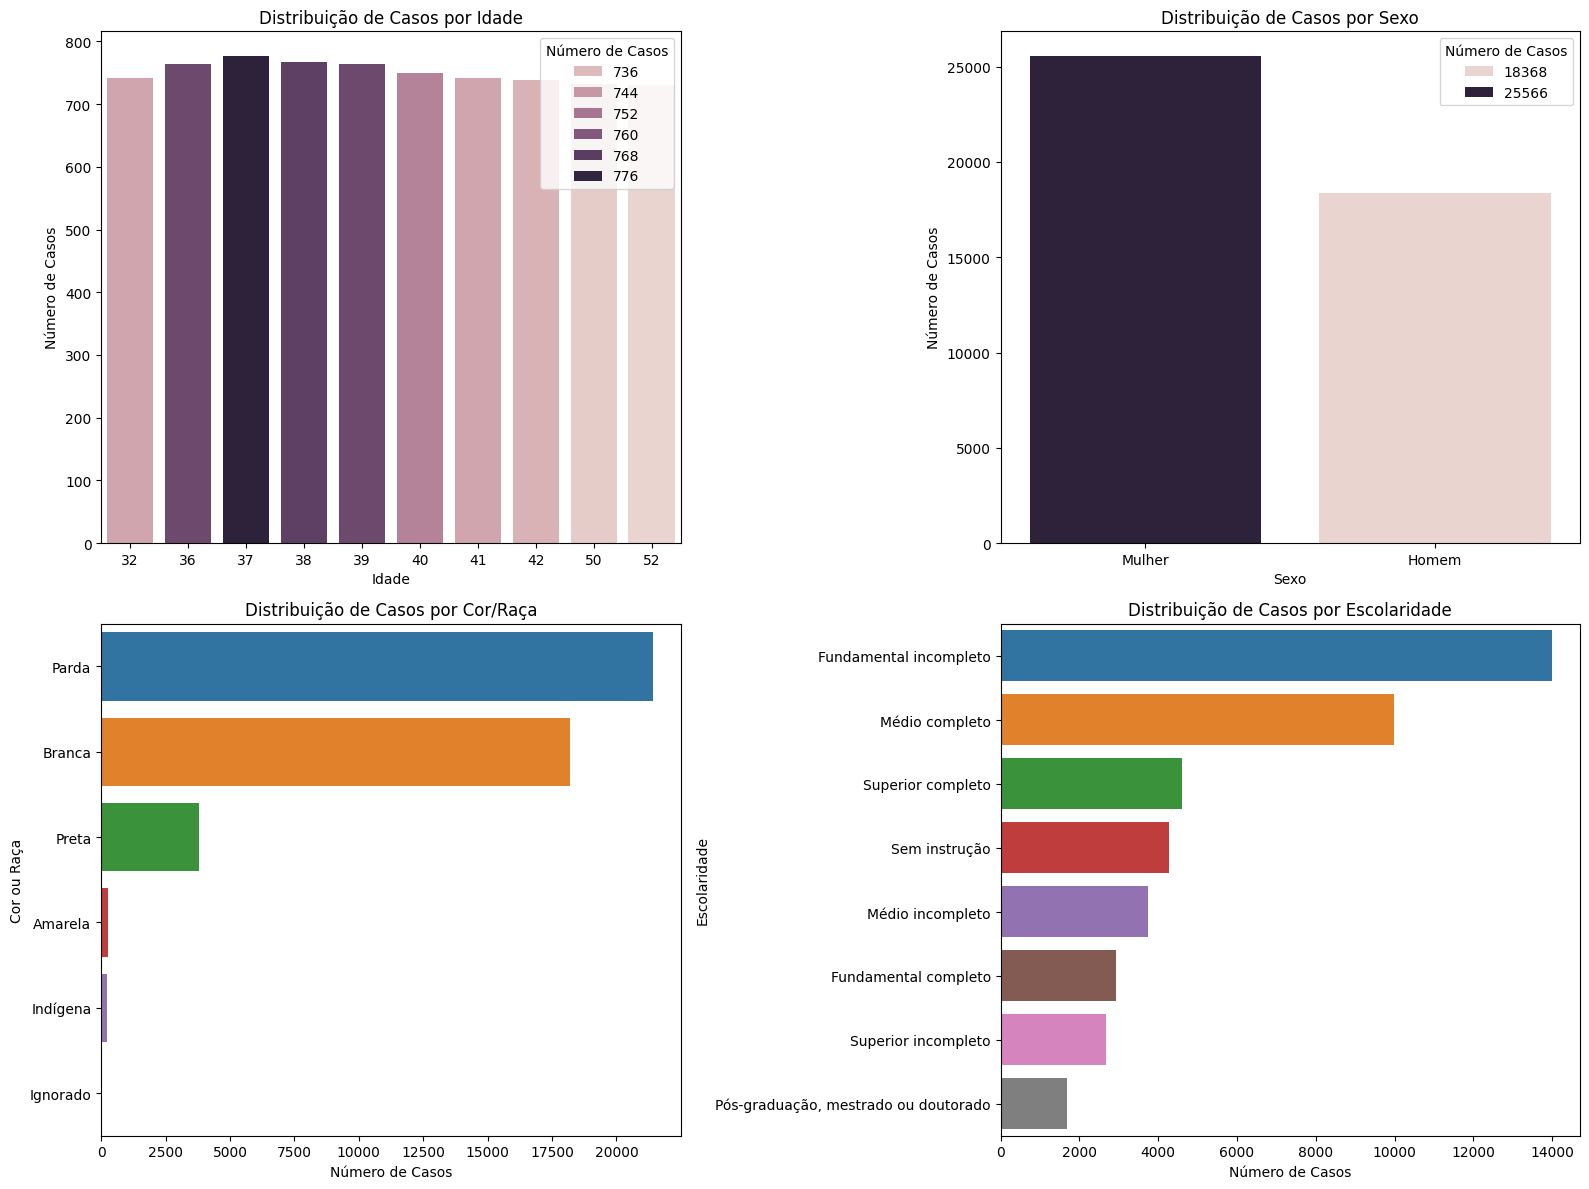

In [19]:
sintomas_cols = [
    "Febre", "Tosse", "Dor de Garganta", "Dificuldade para Respirar", "Dor de Cabeça",
    "Dor no Peito", "Náusea", "Nariz Entupido ou Escorrendo", "Fadiga", "Dor nos Olhos",
    "Perda de Cheiro ou Sabor", "Dor Muscular"
]

df_spark = df_spark.withColumn("Possui Sintomas", F.when(
    sum(F.when(F.col(col) == "Sim", 1).otherwise(0) for col in sintomas_cols) > 0, "Sim"
).otherwise("Não"))

idade_df = df_spark.filter(F.col("Possui Sintomas") == "Sim").groupby("Idade").count().orderBy(F.desc("count"))
sexo_df = df_spark.filter(F.col("Possui Sintomas") == "Sim").groupby("Sexo").count().orderBy(F.desc("count"))
raca_df = df_spark.filter(F.col("Possui Sintomas") == "Sim").groupby("Cor ou Raça").count().orderBy(F.desc("count"))
escolaridade_df = df_spark.filter(F.col("Possui Sintomas") == "Sim").groupby("Escolaridade").count().orderBy(F.desc("count"))

idade_pd = idade_df.toPandas()
sexo_pd = sexo_df.toPandas()
raca_pd = raca_df.toPandas()
escolaridade_pd = escolaridade_df.toPandas()

idade_pd.columns = ["Idade", "Número de Casos"]
sexo_pd.columns = ["Sexo", "Número de Casos"]
raca_pd.columns = ["Cor ou Raça", "Número de Casos"]
escolaridade_pd.columns = ["Escolaridade", "Número de Casos"]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.barplot(data=idade_pd.head(10), x="Idade", y="Número de Casos", hue="Número de Casos", ax=axes[0, 0])
axes[0, 0].set_title("Distribuição de Casos por Idade")
axes[0, 0].set_xlabel("Idade")
axes[0, 0].set_ylabel("Número de Casos")

sns.barplot(data=sexo_pd, x="Sexo", y="Número de Casos", hue="Número de Casos", ax=axes[0, 1])
axes[0, 1].set_title("Distribuição de Casos por Sexo")
axes[0, 1].set_xlabel("Sexo")
axes[0, 1].set_ylabel("Número de Casos")

sns.barplot(data=raca_pd, x="Número de Casos", y="Cor ou Raça", hue="Cor ou Raça", ax=axes[1, 0])
axes[1, 0].set_title("Distribuição de Casos por Cor/Raça")
axes[1, 0].set_xlabel("Número de Casos")
axes[1, 0].set_ylabel("Cor ou Raça")

sns.barplot(data=escolaridade_pd, x="Número de Casos", y="Escolaridade", hue="Escolaridade", ax=axes[1, 1])
axes[1, 1].set_title("Distribuição de Casos por Escolaridade")
axes[1, 1].set_xlabel("Número de Casos")
axes[1, 1].set_ylabel("Escolaridade")

plt.tight_layout()
plt.show()

### Comportamento das Pessoas no Trabalho Presencial

Análise importante para identificarmos potenciais avanços dos casos da doença quando as pessoas continuam indo ao trabalho.

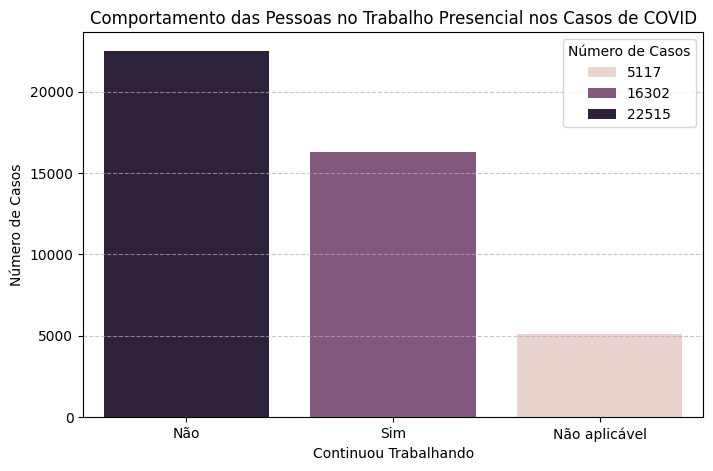

In [20]:
sintomas_cols = [
    "Febre", "Tosse", "Dor de Garganta", "Dificuldade para Respirar", "Dor de Cabeça",
    "Dor no Peito", "Náusea", "Nariz Entupido ou Escorrendo", "Fadiga", "Dor nos Olhos",
    "Perda de Cheiro ou Sabor", "Dor Muscular"
]

df_spark = df_spark.withColumn("Possui Sintomas", F.when(
    sum(F.when(F.col(col) == "Sim", 1).otherwise(0) for col in sintomas_cols) > 0, "Sim"
).otherwise("Não"))

trabalho_df = df_spark.filter(F.col("Possui Sintomas") == "Sim") \
    .groupby("Trabalhou").count().orderBy(F.desc("count"))

trabalho_pd = trabalho_df.toPandas()
trabalho_pd.columns = ["Trabalhou Presencialmente", "Número de Casos"]

plt.figure(figsize=(8, 5))
sns.barplot(data=trabalho_pd, x="Trabalhou Presencialmente", y="Número de Casos", hue="Número de Casos")

plt.xlabel("Continuou Trabalhando")
plt.ylabel("Número de Casos")
plt.title("Comportamento das Pessoas no Trabalho Presencial nos Casos de COVID")

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Comportamento da População

/var/folders/7t/pc2p4mhd0pl7zv35sx2nj4cr0000gp/T/ipykernel_54482/3117127970.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=15)


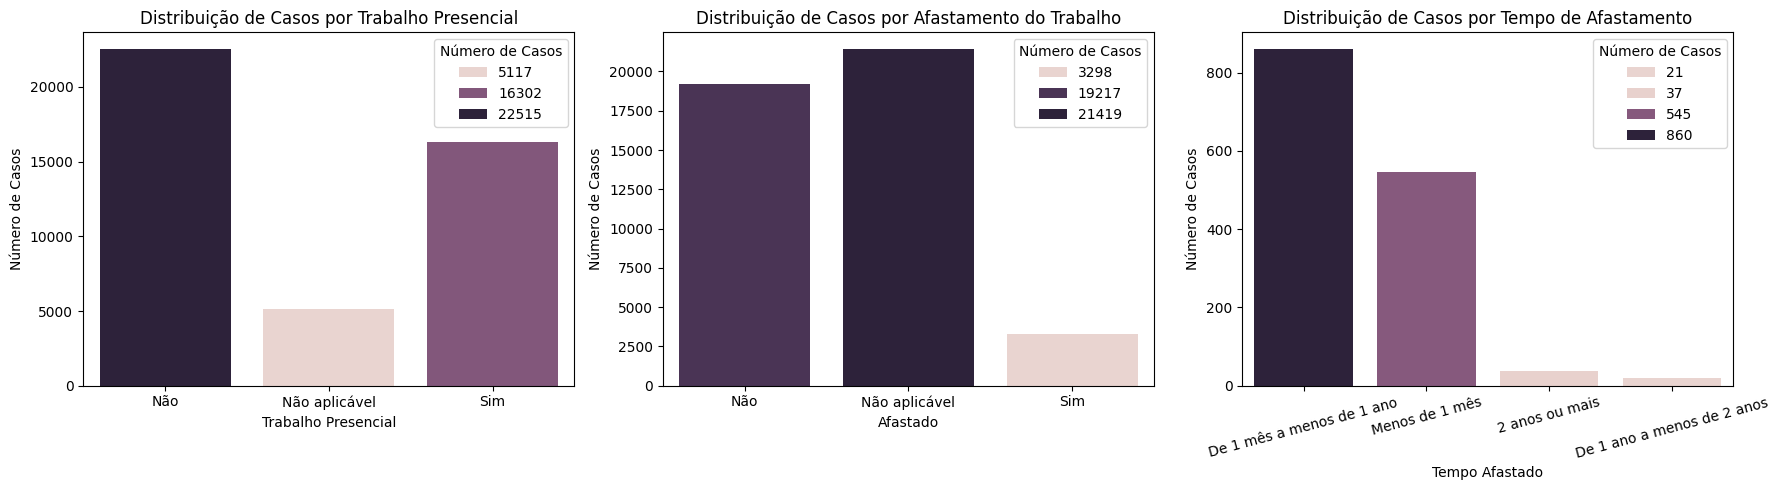

In [21]:
sintomas_cols = [
    "Febre", "Tosse", "Dor de Garganta", "Dificuldade para Respirar", "Dor de Cabeça",
    "Dor no Peito", "Náusea", "Nariz Entupido ou Escorrendo", "Fadiga", "Dor nos Olhos",
    "Perda de Cheiro ou Sabor", "Dor Muscular"
]

df_spark = df_spark.withColumn("Possui Sintomas", F.when(
    sum(F.when(F.col(col) == "Sim", 1).otherwise(0) for col in sintomas_cols) > 0, "Sim"
).otherwise("Não"))

comportamento_cols = ["Trabalhou", "Afastado", "Tempo Afastado"]

comportamento_df = df_spark.filter(F.col("Possui Sintomas") == "Sim") \
    .groupby(comportamento_cols).count().orderBy(F.desc("count"))

comportamento_pd = comportamento_df.toPandas()
comportamento_pd.columns = ["Trabalhou", "Afastado", "Tempo Afastado", "Número de Casos"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(data=comportamento_pd.groupby("Trabalhou").sum().reset_index(),
            x="Trabalhou", y="Número de Casos", hue="Número de Casos", ax=axes[0])
axes[0].set_title("Distribuição de Casos por Trabalho Presencial")
axes[0].set_xlabel("Trabalho Presencial")
axes[0].set_ylabel("Número de Casos")

sns.barplot(data=comportamento_pd.groupby("Afastado").sum().reset_index(),
            x="Afastado", y="Número de Casos", hue="Número de Casos", ax=axes[1])
axes[1].set_title("Distribuição de Casos por Afastamento do Trabalho")
axes[1].set_xlabel("Afastado")
axes[1].set_ylabel("Número de Casos")

sns.barplot(
    data=comportamento_pd[comportamento_pd["Tempo Afastado"] != "Não aplicável"],
    x="Tempo Afastado", 
    y="Número de Casos", 
    hue="Número de Casos", 
    ax=axes[2]
)
axes[2].set_title("Distribuição de Casos por Tempo de Afastamento")
axes[2].set_xlabel("Tempo Afastado")
axes[2].set_ylabel("Número de Casos")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=15)

plt.tight_layout()
plt.show()

## Clusterização

### Pessoas Infectadas por Idade e Número de Casos (K-Means)

O gráfico de dispersão mostra que os grupos possuem padrões diferentes de incidência da doença. O cluster 0 (roxo) representa indivíduos com um número menor de casos, possivelmente trabalhadores afastados ou com menos exposição. O cluster 1 (verde) concentra casos elevados em uma faixa etária mais avançada, sugerindo maior impacto entre idosos. Já o cluster 2 (amarelo) agrupa casos elevados entre indivíduos mais jovens e de meia-idade, indicando maior exposição ou presença em atividades laborais presenciais. Essa análise pode ser útil para direcionar estratégias de prevenção, controle da doença e políticas de saúde pública com base nos perfis mais afetados.

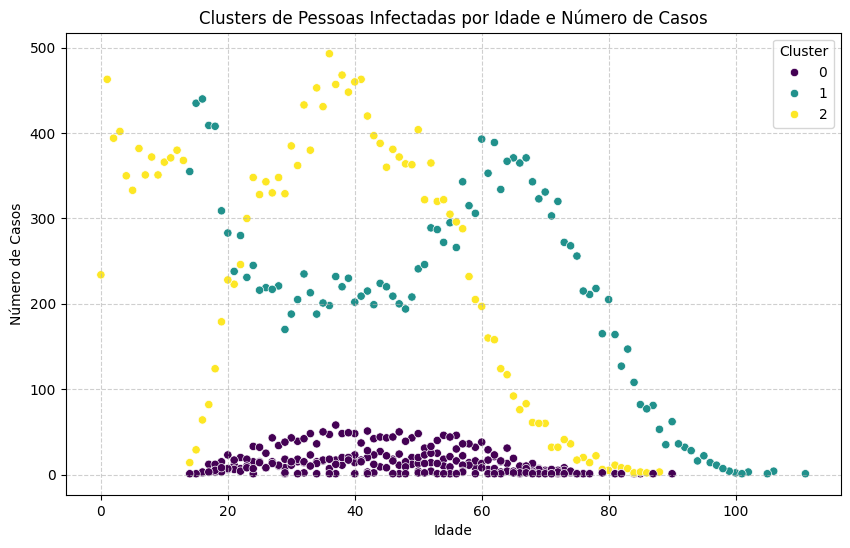

In [22]:
comportamento_df = df_spark.filter(F.col("Possui Sintomas") == "Sim") \
    .select("Idade", "Trabalhou", "Afastado", "Tempo Afastado") \
    .groupby("Idade", "Trabalhou", "Afastado", "Tempo Afastado").count()

comportamento_pd = comportamento_df.toPandas()
comportamento_pd.columns = ["Idade", "Trabalhou", "Afastado", "Tempo Afastado", "Número de Casos"]

comportamento_pd_encoded = pd.get_dummies(comportamento_pd, columns=["Trabalhou", "Afastado", "Tempo Afastado"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(comportamento_pd_encoded.drop(columns=["Número de Casos"]))

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
comportamento_pd_encoded["Cluster"] = kmeans.fit_predict(X_scaled)

comportamento_pd["Cluster"] = comportamento_pd_encoded["Cluster"]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=comportamento_pd, x="Idade", y="Número de Casos", hue="Cluster", palette="viridis")

plt.xlabel("Idade")
plt.ylabel("Número de Casos")
plt.title("Clusters de Pessoas Infectadas por Idade e Número de Casos")
plt.legend(title="Cluster")
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()